# Plots based on Lommis App

In [1]:
## IMPORT LIBRARIES ##
import os
import lommis_func
import warnings
import math
import numpy as np

import pandas as pd
from openpyxl.styles import Alignment
from datetime import datetime, timedelta
from traffic.core import Traffic, Flight

import pyopensky.rest as rest
if not hasattr(rest.REST, "routes"):
    def _routes(self, callsign): return ("", "")
    rest.REST.routes = _routes

from traffic.data import airports, eurofirs, opensky
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartes.crs import Lambert93
from geopy.distance import geodesic
from traffic.core.mixins import PointMixin
from pyproj import Transformer

warnings.simplefilter("ignore")
# Configure matplotlib for publication quality
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 15,
    'lines.linewidth': 1.2,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
})

In [49]:
# Year and Month of the fetching data
year = 2025
month = 3

In [52]:
# Filename and path (same as when saving)
filename = f"{year}-{month:02d}-flights.parquet"
file_path = os.path.join("Statistics/", filename)

# Load the parquet file back into a Traffic object
traff_set_filtered = Traffic.from_file(file_path)
print(f"Loaded flight data from: {file_path}")
print(f"Number of flights loaded: {len(traff_set_filtered)}")

Loaded flight data from: Statistics/2025-03-flights.parquet
Number of flights loaded: 189


## Draw Take-off and Departures

In [ ]:
def draw_compass(ax, center_x, center_y, size=0.05):
    """
    Draws a compass rose (N, E, S, W) on the given axes.
    
    Parameters:
        ax: Matplotlib axes to draw the compass on.
        center_x: X-coordinate of the compass center (normalized coordinates).
        center_y: Y-coordinate of the compass center (normalized coordinates).
        size: Size of the compass (proportional to axes size).
    """
    # Compass directions
    directions = ['N', 'E', 'S', 'W']
    offsets = [(0, size), (0.5*size, 0), (0, -size), (-0.5*size, 0)]

    # Add labels for each direction
    for direction, (dx, dy) in zip(directions, offsets):
        ax.text(center_x + dx, center_y + dy, direction, 
                transform=ax.transAxes, fontsize=15, fontweight='bold', 
                ha='center', va='center')
        
def determine_entry_direction(entry_lat, entry_lon, center_lat, center_lon):
    """
    Determines the direction the aircraft is coming from based on entry coordinates 
    relative to the circle center.
    """
    delta_lat = entry_lat - center_lat  # Difference in latitude
    delta_lon = entry_lon - center_lon  # Difference in longitude

    if abs(delta_lat) > abs(delta_lon):  # Prioritize N/S over E/W
        return 'N' if delta_lat > 0 else 'S'
    else:
        return 'E' if delta_lon > 0 else 'W'

In [ ]:
flight = traff_set_filtered[15]

In [ ]:
import lommis_func
from cartes.crs import Lambert93
from geopy.distance import geodesic
from traffic.core.mixins import PointMixin
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True)

# DEFINE RUNWAY EXTREME POINTS #
extreme1 = PointMixin()
extreme2 = PointMixin()
extreme1.latitude = 47.5257
extreme1.longitude = 9.0068
extreme2.latitude = 47.5233
extreme2.longitude = 8.9996
extreme1.name = "Runway Threshold 24"
extreme2.name = "Runway Threshold 06"

# DEFINE CIRCLE CENTER #
center = PointMixin()
center.latitude = (extreme1.latitude + extreme2.latitude) / 2
center.longitude = (extreme1.longitude + extreme2.longitude) / 2

# DEFINE RADIUS #
upper_coords = (47.562333, 8.986976) 
radius = geodesic((center.latitude, center.longitude), upper_coords)

# FLIGHT AND CORRESPONDING BOOL'S #
flight = flight.filter(
    filter='default',
    strategy=lambda x: x.ffill().bfill().infer_objects(copy=False)
)
landing_lszt = flight.landing_at(airports["LSZT"]) # landing bool #
takeoff_lszt = flight.takeoff_from(airports["LSZT"]) # takeoff bool #

plot_departure = False
if takeoff_lszt:
    starting_flight = flight.query(f"vertical_rate > {flight.data.vertical_rate.iloc[0]}").first('1 min')

    d_24 = starting_flight.closest_point(extreme1)
    d_06 = starting_flight.closest_point(extreme2)

    if d_06.timestamp > d_24.timestamp:
        rwy = '24 G'
        #route_takeoff = 'W'
        
        departure_time = d_06.timestamp
        departure_orientation = d_06.track
    else:
        rwy = '06 G'

        departure_time = d_24.timestamp
        departure_orientation = d_24.track

    # Compute route_takeoff using entry direction detection
    dist = flight.distance(center)
    small_dist = dist.data[dist.data.distance.between(radius.nm - 0.1, radius.nm + 0.1)]
    small_dist.sort_values(by="timestamp")

    if len(small_dist) > 0:
        small_dist = small_dist.copy()
        small_dist["time_diff"] = small_dist["timestamp"].diff().dt.total_seconds()
        small_dist["crossing_id"] = (small_dist["time_diff"] > 120).fillna(False).astype(int).cumsum()

        crossing_events = small_dist.groupby("crossing_id").agg(
            entry_timestamp=("timestamp", "first"),
            entry_latitude=("latitude", "first"),
            entry_longitude=("longitude", "first"),
        ).reset_index(drop=True)

        # Determine route_takeoff direction
        if len(crossing_events) > 0:
            route_takeoff = lommis_func.determine_direction(
                crossing_events.iloc[0]["entry_latitude"], 
                crossing_events.iloc[0]["entry_longitude"], 
                center.latitude, 
                center.longitude)
    else:
        route_takeoff = "Unknown"

    takeoff_flight = flight.between(departure_time, departure_time + pd.Timedelta('1 min'))

    #print(f"Distance to Extreme 06: {d_24.timestamp} | Distance to Extreme 24: {d_06.timestamp}")
    #print(f"Departure orientation: {departure_orientation}")
    print("------------------------------------------------")
    print(f"START FLIGHT: {flight.data.timestamp.iloc[0]}")
    print(f"DEPARTURE: {departure_time}")
    print(f"RUNWAY: {rwy}")
    print(f"ROUTE: {route_takeoff}")
    print("------------------------------------------------")
    plot_departure = True

plot_arrival = False
if landing_lszt:
    last_change_index = flight.data.iloc[::-1].vertical_rate.ne(flight.data.vertical_rate.iloc[-1]).idxmax()
    ending_flight = flight.query(f"index <= {last_change_index}").last('1 min')

    d_24 = ending_flight.closest_point(extreme1)
    d_06 = ending_flight.closest_point(extreme2)    

    if d_06.timestamp < d_24.timestamp:
        rwy = '06 G'

        landing_time = d_06.timestamp
        arrival_orientation = d_06.track
    else:
        rwy = '24 G'

        landing_time = d_24.timestamp
        arrival_orientation = d_24.track
   
    # Compute route_landing using entry direction detection
    dist = flight.distance(center)
    small_dist = dist.data[dist.data.distance.between(radius.nm - 0.1, radius.nm + 0.1)]
    small_dist.sort_values(by="timestamp")

    if len(small_dist) > 0:
        small_dist = small_dist.copy()
        small_dist["time_diff"] = small_dist["timestamp"].diff().dt.total_seconds()
        small_dist["crossing_id"] = (small_dist["time_diff"] > 120).fillna(False).astype(int).cumsum()

        crossing_events = small_dist.groupby("crossing_id").agg(
            entry_timestamp=("timestamp", "first"),
            entry_latitude=("latitude", "first"),
            entry_longitude=("longitude", "first"),
        ).reset_index(drop=True)

        # Determine route_landing direction
        if len(crossing_events) > 0:
            if takeoff_lszt: pos_landing = 1
            else: pos_landing = 0

        route_landing = lommis_func.determine_direction(
            crossing_events.iloc[pos_landing]["entry_latitude"], 
            crossing_events.iloc[pos_landing]["entry_longitude"], 
            center.latitude, 
            center.longitude
        )
    else:
        route_landing = "Unknown"

    #print(f"DISTANCE Runway Threshold 24: {d_24.distance} and Runway Threshold 06: {d_06.distance}")
    #print(f"TIME Runway Threshold 24: {d_24.timestamp} and Runway Threshold 06: {d_06.timestamp}")

    landing_flight = flight.between(landing_time - pd.Timedelta('1 min'), landing_time)
    extended_landing_flight = flight.between( crossing_events.iloc[pos_landing].entry_timestamp , landing_time - pd.Timedelta('1 min'))
    #print(f"Arrival orientation: {arrival_orientation}")
    print("------------------------------------------------")
    print(f"LANDING: {landing_time}")
    print(f"END FLIGHT: {flight.data.timestamp.iloc[-1]}")
    print(f"RUNWAY: {rwy}")
    print(f"ROUTE: {route_landing}")
    print("------------------------------------------------")
    plot_arrival = True

if plot_arrival or plot_departure:
    # Fix figure size for better proportions (balanced width/height)
    fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True, subplot_kw=dict(projection=Lambert93()))
    airports['LSZT'].plot(ax, labels=dict(fontsize=22))

    # ---- PLOT FLIGHT PATHS ---- #
    if plot_departure:
        takeoff_flight.plot(ax, linestyle=(0, (1, 0)), color='b', label='Departure Flight')
        for i in range(0, len(takeoff_flight.data) - 1, 3):
            lat_start, lon_start = takeoff_flight.data.iloc[i][['latitude', 'longitude']]
            lat_end, lon_end = takeoff_flight.data.iloc[i + 1][['latitude', 'longitude']]
            x_start, y_start = transformer.transform(lon_start, lat_start)
            x_end, y_end = transformer.transform(lon_end, lat_end)
            ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                        arrowprops=dict(arrowstyle='->', color='b', lw=2))

    if plot_arrival:
        landing_flight.plot(ax, color='r', linestyle=(0, (1, 0)), label='Arrival Flight')
        for i in range(0, len(landing_flight.data) - 1, 3):
            lat_start, lon_start = landing_flight.data.iloc[i][['latitude', 'longitude']]
            lat_end, lon_end = landing_flight.data.iloc[i + 1][['latitude', 'longitude']]
            x_start, y_start = transformer.transform(lon_start, lat_start)
            x_end, y_end = transformer.transform(lon_end, lat_end)
            ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                        arrowprops=dict(arrowstyle='->', color='r', lw=1.5))

        #extended_landing_flight.plot(ax, linestyle=':', color='gray', label='Extended Landing Flight', linewidth=1)

    # ---- ADD FLIGHT INFORMATION TEXT BOX ---- #
    info_text = ""
    
    if plot_departure:
        info_text += f"DEPARTURE:"
        info_text += f"\nStart Flight: {flight.data.timestamp.iloc[0].strftime('%H:%M:%S')}"
        info_text += f"\nDeparture: {departure_time.strftime('%H:%M:%S')}"
        info_text += f"\nRunway: {rwy}"
        info_text += f"\nRoute: {route_takeoff}"
    
    if plot_arrival:
        if plot_departure:
            info_text += f"\n\nARRIVAL:"
        else:
            info_text += f"ARRIVAL:"
        info_text += f"\nLanding: {landing_time.strftime('%H:%M:%S')}"
        info_text += f"\nEnd Flight: {flight.data.timestamp.iloc[-1].strftime('%H:%M:%S')}"
        info_text += f"\nRunway: {rwy}"
        info_text += f"\nRoute: {route_landing}"

    ax.text(1.38, 0.98, info_text,
            transform=ax.transAxes, fontsize=18, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

    # ---- FIX COMPASS POSITION (Bottom Left) ---- #
    draw_compass(ax, center_x=0.9, center_y=0, size=0.06)  # Adjust position as needed

    # ---- FIX LEGEND POSITION (Bottom Right) ---- #
    ax.legend(loc="lower right", bbox_to_anchor=(1.4, 0.05), frameon=True, fontsize=16)

    # ---- FINAL DISPLAY ---- #
    ax.spines['geo'].set_visible(False)
    plt.show()


## Runway Capture Area

In [ ]:
# Enhanced visualization of create_runway_area function capabilities
import altair as alt
import folium
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import numpy as np
import cartopy.crs as ccrs
from cartes.crs import Lambert93
from pyproj import Transformer

# Set up airport and runway
airport = airports["LSZT"]
runway = '24'

print(f"Demonstrating create_runway_area for {airport.icao} runway {runway}")

# Create multiple runway areas with different scale factors, largest first
scales = [4.0, 2.0, 1.5, 1.0]
colors = ['thistle', 'lightblue', 'gold', 'salmon']  # pale thistle, lightblue, gold, reddish
alphas = [0.5, 0.7, 0.8, 1.0] # NO TOQUES ESTO PEDAZO DE GILIPOLLAS

print(f"Created {len(scales)} runway areas with different scale factors")

# Transformer for coordinates
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154")  # WGS84 to Lambert93

# Enhanced matplotlib visualization with proper airport plotting
with plt.style.context('traffic'):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=72, subplot_kw=dict(projection=Lambert93()))
    
    # Plot the airport with runways and labels
    airports['LSZT'].plot(ax, labels=dict(fontsize=25))
    
    # Plot multiple runway areas with different scale factors
    for i, (scale, color, alpha) in enumerate(zip(scales, colors, alphas)):
        runway_area = lommis_func.create_runway_area(airport, runway, scale=scale, debug=False)
        area_coords = [(coord[1], coord[0]) for coord in runway_area[:-1]]  # [lon, lat], exclude duplicate
        polygon = Polygon(area_coords, facecolor=color, edgecolor='blue', 
                         alpha=alpha, linewidth=2, label=f'Scale={scale}',
                         transform=ccrs.PlateCarree())
        ax.add_patch(polygon)
    
    # Add sample flight trajectories for context
    if len(traff_set_filtered) > 0:
        # Sample flights - different types of patterns
        sample_flights = [
            (traff_set_filtered[2].first('2.5min'), 'Outbound', 'red'),
            (traff_set_filtered[3].last('4.5min'), 'Traffic Circuit', 'green'), 
            (traff_set_filtered[26].last('3min'), 'Inbound', 'magenta')
        ]
        
        for flight, label, color in sample_flights:
            try:
                flight.plot(ax, color=color, alpha=0.7, linewidth=1.5, label=label)
                # Add arrows for direction, every 50 points to reduce memory
                for i in range(0, len(flight.data) - 1, 50):
                    lat_start, lon_start = flight.data.iloc[i][['latitude', 'longitude']]
                    lat_end, lon_end = flight.data.iloc[i + 1][['latitude', 'longitude']]
                    x_start, y_start = transformer.transform(lon_start, lat_start)
                    x_end, y_end = transformer.transform(lon_end, lat_end)
                    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                                arrowprops=dict(arrowstyle='->', color=color, lw=1.5))
            except:
                pass  # Skip if flight can't be plotted
    
    # Create comprehensive legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=3, label=f'Airport {airport.icao}'),
        Line2D([0], [0], color='thistle', linewidth=8, alpha=0.4, label='Scale=4.0'),
        Line2D([0], [0], color='lightblue', linewidth=8, alpha=0.5, label='Scale=2.0'),
        Line2D([0], [0], color='gold', linewidth=8, alpha=0.6, label='Scale=1.5'),
        Line2D([0], [0], color='salmon', linewidth=8, alpha=0.8, label='Scale=1.0'),
        Line2D([0], [0], color='red', linewidth=2, label='Sample Outbound'),
        Line2D([0], [0], color='green', linewidth=2, label='Sample Circuit'),
        Line2D([0], [0], color='magenta', linewidth=2, label='Sample Inbound')
    ]
    
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.5), loc='upper left', fontsize=12)
       
    # Remove the geographic spines for cleaner look
    ax.spines['geo'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Comprehensive Traffic Circuits Plot - Recreated
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartes.crs import Lambert93
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

# Configure for high-quality publication plot
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'lines.linewidth': 1.5,
    'axes.linewidth': 0.8,
    'figure.dpi': 300
})

# Create figure with multiple subplots showing different circuit types
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.25)

# Define different circuit scenarios to showcase
circuit_scenarios = [
    {"title": "Normal Right-Hand Circuit", "flights": [0, 3, 7], "color_scheme": "standard"},
    {"title": "Left-Hand Circuit Pattern", "flights": [1, 5, 9], "color_scheme": "alternative"}, 
    {"title": "Multiple Circuit Training", "flights": [2, 6, 8, 11], "color_scheme": "training"},
    {"title": "Mixed Traffic Patterns", "flights": [4, 10, 12, 15], "color_scheme": "mixed"}
]

color_schemes = {
    "standard": ['#1f77b4', '#ff7f0e', '#2ca02c'],
    "alternative": ['#d62728', '#9467bd', '#8c564b'], 
    "training": ['#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
    "mixed": ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
}

# Plot each scenario
for idx, scenario in enumerate(circuit_scenarios):
    row = idx // 2
    col = idx % 2
    ax = fig.add_subplot(gs[row, col], projection=Lambert93())
    
    # Plot airport
    airports['LSZT'].plot(ax, labels=dict(fontsize=16))
    
    # Plot runway capture area for context
    runway_area = lommis_func.create_runway_area(airports["LSZT"], '24', scale=1.5, debug=False)
    area_coords = [(coord[1], coord[0]) for coord in runway_area[:-1]]
    polygon = Polygon(area_coords, facecolor='lightblue', edgecolor='blue', 
                     alpha=0.3, linewidth=1, transform=ccrs.PlateCarree())
    ax.add_patch(polygon)
    
    # Plot selected flights for this scenario
    colors = color_schemes[scenario["color_scheme"]]
    flight_labels = []
    
    for i, flight_idx in enumerate(scenario["flights"]):
        if flight_idx < len(traff_set_filtered):
            flight = traff_set_filtered[flight_idx]
            color = colors[i % len(colors)]
            
            try:
                # Analyze circuit characteristics
                results, predictions, ncircuits, indexes = lommis_func.find_aerodrome_circuits(
                    flight, airports['LSZT'], rwy='24', scale=1.5, debug=False, plot=False
                )
                
                # Plot the flight path
                flight.plot(ax, color=color, alpha=0.8, linewidth=2)
                
                # Create label based on circuit analysis
                if ncircuits > 0:
                    circuit_type = "Circuit" if predictions[0] == 1 else "Approach"
                    label = f"Flight {flight_idx+1}: {circuit_type}"
                else:
                    # Determine if it's arrival, departure, or transit
                    landing = flight.landing_at(airports["LSZT"])
                    takeoff = flight.takeoff_from(airports["LSZT"])
                    
                    if landing and takeoff:
                        label = f"Flight {flight_idx+1}: Touch & Go"
                    elif landing:
                        label = f"Flight {flight_idx+1}: Arrival"
                    elif takeoff:
                        label = f"Flight {flight_idx+1}: Departure"
                    else:
                        label = f"Flight {flight_idx+1}: Transit"
                
                flight_labels.append((color, label))
                
            except Exception as e:
                # Fallback: just plot the flight
                flight.plot(ax, color=color, alpha=0.8, linewidth=2)
                flight_labels.append((color, f"Flight {flight_idx+1}"))
    
    # Formatting
    ax.set_title(scenario["title"], fontsize=14, fontweight='bold', pad=20)
    ax.spines['geo'].set_visible(False)
    
    # Create legend for this subplot
    legend_elements = [Line2D([0], [0], color=color, linewidth=2, label=label) 
                      for color, label in flight_labels]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.0, 1.0), 
             fontsize=9, frameon=True, facecolor='white', edgecolor='black')

# Add main title
fig.suptitle('Aerodrome Traffic Circuit Patterns Analysis\nLSZT Airport - Various Flight Scenarios', 
             fontsize=16, fontweight='bold', y=0.95)

# Add comprehensive legend at the bottom
main_legend_elements = [
    Line2D([0], [0], color='lightblue', linewidth=8, alpha=0.6, label='Runway Capture Area'),
    Line2D([0], [0], color='black', linewidth=3, label='Airport/Runway'),
    Line2D([0], [0], color='#1f77b4', linewidth=2, label='Standard Circuits'),
    Line2D([0], [0], color='#d62728', linewidth=2, label='Alternative Patterns'),
    Line2D([0], [0], color='#e377c2', linewidth=2, label='Training Flights'),
    Line2D([0], [0], color='#ff9999', linewidth=2, label='Mixed Traffic')
]

fig.legend(handles=main_legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), 
          ncol=3, fontsize=11, frameon=True, facecolor='white', edgecolor='black')

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

# Print summary statistics
print("Traffic Circuit Analysis Summary:")
print("=" * 50)
for idx, scenario in enumerate(circuit_scenarios):
    total_circuits = 0
    total_flights = len([f for f in scenario["flights"] if f < len(traff_set_filtered)])
    
    for flight_idx in scenario["flights"]:
        if flight_idx < len(traff_set_filtered):
            try:
                _, _, ncircuits, _ = lommis_func.find_aerodrome_circuits(
                    traff_set_filtered[flight_idx], airports['LSZT'], 
                    rwy='24', scale=1.5, debug=False, plot=False
                )
                total_circuits += ncircuits
            except:
                pass
    
    print(f"{scenario['title']}: {total_flights} flights, {total_circuits} total circuits")

In [ ]:
# LIPQ runway capture area — clean view without grid/axes labels
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

# Airport and runway
airport = airports["LSZT"]
runway = '06'

# Build runway area
runway_area = lommis_func.create_runway_area(airport, runway, scale=1.0, debug=False)

with plt.style.context('traffic'):
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

    # Airport (runways + label)
    airport.plot(ax)

    # Capture area polygon
    area_coords = [(coord[1], coord[0]) for coord in runway_area[:-1]]  # (lon, lat)
    polygon = Polygon(area_coords, facecolor='lightblue', edgecolor='blue', alpha=0.6,
                      linewidth=2, transform=ccrs.PlateCarree())
    ax.add_patch(polygon)

    # Corner markers + plain letter labels (no circles) - closer to points
    corner_coords = runway_area[:4]
    corner_labels = ['A', 'B', 'C', 'D']
    corner_colors = ['red', 'green', 'orange', 'purple']

    for i, (coord, label, color) in enumerate(zip(corner_coords, corner_labels, corner_colors)):
        lat, lon = coord[0], coord[1]
        ax.plot(lon, lat, 'o', color=color, markersize=10, markeredgecolor='black',
                markeredgewidth=1.5, transform=ccrs.PlateCarree(), zorder=10)
        # Smaller offset for labels to be closer to points
        offset_lon = 0.0003 if i % 2 == 0 else -0.0003
        offset_lat = 0.0003 if i < 2 else -0.0003
        ax.text(lon + offset_lon, lat + offset_lat, label,
                fontsize=24, fontweight='bold', color=color,
                ha='center', va='center', transform=ccrs.PlateCarree(), zorder=11)

    # Runway thresholds
    runway_data = airport.runways.data
    runway_lons = []
    runway_lats = []
    if len(runway_data) >= 2:
        runway_lons = [runway_data.longitude.iloc[0], runway_data.longitude.iloc[1]]
        runway_lats = [runway_data.latitude.iloc[0], runway_data.latitude.iloc[1]]
        
        ax.plot(runway_lons, runway_lats, 's', color='black', markersize=8, markeredgewidth=1.5, markeredgecolor='white',
                transform=ccrs.PlateCarree(), zorder=9)

        # Add threshold labels
        ax.text(runway_lons[0] + 0.0004, runway_lats[0] + 0.00005, '24', fontsize=24, ha='center', va='bottom', 
                transform=ccrs.PlateCarree(), zorder=13)
        ax.text(runway_lons[1], runway_lats[1] - 0.0006, '06', fontsize=24, ha='center', va='bottom', 
                transform=ccrs.PlateCarree(), zorder=13)

    # Runway center with diamond marker (yellow with black edge)
    if len(runway_lons) >= 2 and len(runway_lats) >= 2:
        runway_center_lon = (runway_lons[0] + runway_lons[1]) / 2
        runway_center_lat = (runway_lats[0] + runway_lats[1]) / 2
        ax.plot(runway_center_lon, runway_center_lat, 'D', color='yellow', markersize=12, 
                markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree(), zorder=12)

    # Determine tight extent from all plotted data (polygon + runway)
    all_lons = [x for x, y in area_coords] + runway_lons
    all_lats = [y for x, y in area_coords] + runway_lats
    if len(all_lons) and len(all_lats):
        lon_min, lon_max = float(np.min(all_lons)), float(np.max(all_lons))
        lat_min, lat_max = float(np.min(all_lats)), float(np.max(all_lats))
        # add a small padding
        pad_lon = max(0.002, 0.1 * (lon_max - lon_min))
        pad_lat = max(0.002, 0.1 * (lat_max - lat_min))
        ax.set_xlim(lon_min - pad_lon, lon_max + pad_lon)
        ax.set_ylim(lat_min - pad_lat, lat_max + pad_lat)

    # Optional coastline for context (kept subtle)
    ax.coastlines(resolution='10m', color='gray', alpha=0.5, linewidth=1)

    # Create legend
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=3, alpha=0.7, label='Runway'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markeredgecolor='white', markeredgewidth=1.5,
               markersize=8, label='Runway Thresholds', linestyle='None'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='yellow', markeredgecolor='black', markeredgewidth=1.5, 
               markersize=10, label='Runway Center', linestyle='None'),
        Line2D([0], [0], color='lightblue', linewidth=6, alpha=0.6, label=f'Capture Area (Scale = 1.0)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black',
               markersize=8, label='Corner A', linestyle='None'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markeredgecolor='black',
               markersize=8, label='Corner B', linestyle='None'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markeredgecolor='black',
               markersize=8, label='Corner C', linestyle='None'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markeredgecolor='black',
               markersize=8, label='Corner D', linestyle='None'),
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.92, 0.85), 
              fontsize=20) #frameon=True, fancybox=True, shadow=True

    # Clean look: no grid, no axis labels, no title
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines['geo'].set_visible(False)

plt.tight_layout()
plt.show()

## PH-AXB Plots flights

In [ ]:
# 21 feb 2025
# icao24 486740

# t = opensky.history(
#     start="2025-03-13 00:00",
#     stop="2025-03-14 00:00",
#     callsign="HBKLA"
#     #airports="LSZT",
# )
# t

t = opensky.history(
    start="2024-12-05 01:00",
    stop="2024-12-06 01:00",
    icao24='486740',
)
t

#convert flights Timestamp to 'datetime64'
t.data['timestamp'] = t.data['timestamp'].dt.tz_convert(None).astype('datetime64[ns]')
t.data['timestamp'] = t.data['timestamp'].dt.tz_localize('UTC')

In [ ]:
predictions

In [ ]:
import joblib
#import keras

# Get results, predictions, and circuit info from the analysis
results, predictions, ncircuits, indexes = lommis_func.find_aerodrome_circuits(
    t[4], 
    airports['LIPQ'], 
    rwy='09', 
    scale=1.5, 
    debug=False, 
    plot=False,
    #model = keras.models.load_model("ML/Models/LSTM/laststep_best.h5") #joblib.load("ML/Models/LSTM/laststep_best.h5")
)

print(f"Found {ncircuits} airdrome circuits")
print(f"Number of segments: {len(results)}")

# Create publication-quality academic plot - ONE SEGMENT PER ROW
fig = plot_flight_segments_academic(
    results, 
    airports['LIPQ'],
    segment_indices=[0,2,3] if len(results) > 1 else [0],  # Select segments
    features=['distance', 'angle', 'altitude', 'track', 'map'],  # Now includes map support
    layout_type='grid',  # Grid layout: one segment per row, features as columns
    figure_size=(18, 8),  # Adjusted size for grid layout
    predictions=["FALSE", "TRUE", "TRUE", "FALSE"],
    color_scheme='ieee',  # Professional color scheme
    #
    # save_path='Statistics/flight_analysis_paper.pdf',
    dpi=300
)

plt.show()

In [ ]:
lommis_func.find_aerodrome_circuits(
    t[3], airports['LIPQ'], 
    rwy='09', scale=1.5, debug=False, plot=True)

## Plot traffic cicuits trajectories

In [147]:
traff_set_filtered[61].map_leaflet(zoom=10)

Map(center=[47.48408506413807, 9.052152390744787], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [149]:
# 1
flight = traff_set_filtered[61] # 15
airport = flight.infer_airport("takeoff")
rwy, _ = lommis_func.detect_runway(flight, airport)

_ = lommis_func.find_aerodrome_circuits(
    flight, airport,
    rwy=rwy, scale=1.25, debug=False, plot=True)

In [173]:
# Define the time offset from start (in seconds)
airplane_time_offset = 70
addRotation = 0
addLatitude = 0.0003
addLongitude = 0

In [72]:
airport.runways.data

,latitude,longitude,bearing,name
0,47.5257,9.0068,243.800221,06
1,47.5233,8.9996,63.794910,24


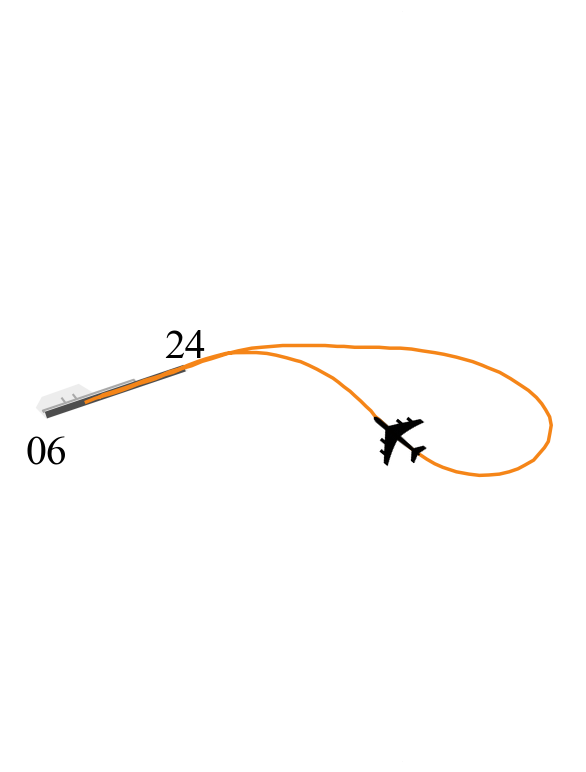

In [174]:
with plt.style.context('traffic'):
    # Set desired pixel dimensions
    desired_width_px = 600  # Horizontal pixels
    desired_height_px = 600  # Vertical pixels
    dpi = 100  # Dots per inch
    
    # Calculate figsize in inches
    figsize = (desired_width_px / dpi, desired_height_px / dpi)
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, subplot_kw=dict(projection=ccrs.PlateCarree()))

    # Plot the flight trajectory
    #trajectory = flight.between("2025-03-08 09:56:50", "2025-03-08 10:01:00")
    
    #flight.between("2025-03-10 10:42:50", "2025-03-10 10:47:50") : 5
    #flight.between("2025-02-07 15:20:20", "2025-02-07 15:39:00") : 31 
    #  : 50
    trajectory = flight.between("2025-03-31 15:03:00", "2025-03-31 15:04:59")
    #flight.between("2025-03-13 15:22:45", "2025-03-13 15:25:30") # : 50
    trajectory.plot(ax, color="#f58518", zorder=3, linewidth=2.5)
    airport.plot(ax)
    
    # Add runway threshold labels
    runway_data = airport.runways.data
    if len(runway_data) >= 2:
        runway_lons = [runway_data.longitude.iloc[0], runway_data.longitude.iloc[1]]
        runway_lats = [runway_data.latitude.iloc[0], runway_data.latitude.iloc[1]]
        
        # Add threshold labels
        ax.text(runway_lons[0], runway_lats[0] + 0.00012, '24', fontsize=30, ha='center', va='bottom', 
                transform=ccrs.PlateCarree(), zorder=13)
        ax.text(runway_lons[1], runway_lats[1] - 0.0030, '06', fontsize=30, ha='center', va='bottom', 
                transform=ccrs.PlateCarree(), zorder=13)
    
    # Find airplane position at specified time offset
    data = trajectory.data.copy()
    start_time = data.iloc[0]['timestamp']
    target_time = start_time + pd.Timedelta(seconds=airplane_time_offset)
    
    # Find the closest timestamp to our target time using POSITION-based indexing
    time_diffs = abs(data['timestamp'] - target_time)
    closest_position = time_diffs.argmin()  # Use argmin() for position, not idxmin() for index
    airplane_point = data.iloc[closest_position]
    
    # Get the next point to calculate direction
    if closest_position + 1 < len(data):
        next_point = data.iloc[closest_position + 1]
        
        # Calculate angle from horizontal line to the vector (current -> next point)
        airplane_rotation = math.degrees(math.atan2(
            next_point['latitude'] - airplane_point['latitude'],
            next_point['longitude'] - airplane_point['longitude']
        ))
    else:
        # If no next point available, use current track
        airplane_rotation = 0

    # Coordinates with manual offsets
    lon = airplane_point['longitude'] + addLongitude
    lat = airplane_point['latitude'] + addLatitude

    # Use airplane emoji with a font that supports emojis (Arial Unicode MS for Windows)
    ax.text(lon, lat + addLatitude, '✈️', ha='center', va='center',
            fontsize=60, color='black', weight='bold',
            rotation=airplane_rotation + addRotation,
            transform=ccrs.PlateCarree(), zorder=10,
            fontname='Arial Unicode MS')

    # Debug dots (keep for reference)
    ax.text(lon, lat + 0.022, '.', fontsize=1, transform=ccrs.PlateCarree(), zorder=11)
    ax.text(lon, lat - 0.017, '.', fontsize=1, transform=ccrs.PlateCarree(), zorder=11)
    
    ax.spines['geo'].set_visible(False)
    ax.autoscale()
plt.tight_layout()
plt.show()

## Plot segmented traffic circuits

In [ ]:
def plot_flight_segments_academic(results: np.ndarray, airport: str, segment_indices: list = None, 
                                 features: list = None, layout_type: str = 'grid', 
                                 figure_size: tuple = (12, 8), show_predictions: bool = True, 
                                 predictions: list = None, color_scheme: str = 'nature',
                                 save_path: str = None, dpi: int = 300):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.gridspec import GridSpec
    from matplotlib.ticker import FuncFormatter
    import numpy as np
    
    # Configure matplotlib for publication quality
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 20,
        'axes.labelsize': 18,
        'axes.titlesize': 18,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15,
        'legend.fontsize': 15,
        'lines.linewidth': 1.2,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.minor.width': 0.6,
        'ytick.minor.width': 0.6,
    })
    
    # Default parameters
    if segment_indices is None:
        segment_indices = list(range(len(results)))
    
    if features is None:
        features = ['distance', 'angle', 'altitude']
    
    # Validate segment indices
    segment_indices = [i for i in segment_indices if i < len(results)]
    num_selected_segments = len(segment_indices)
    
    if num_selected_segments == 0:
        raise ValueError("No valid segments selected")
    
    # Feature configuration
    feature_config = {
        'distance': {
            'title': 'Distance  to \n Runway',
            'ylabel': 'Distance to \n  Runway (NM)',
            'color_idx': 0,
            'data_idx': 0
        },
        'angle': {
            'title': 'Horizontal Angle',
            'ylabel': 'Horizontal Angle (deg.)',
            'color_idx': 1,
            'data_idx': 1
        },
        'altitude': {
            'title': 'Altitude',
            'ylabel': 'Altitude (ft)',
            'color_idx': 2,
            'data_idx': 2
        },
        'track': {
            'title': 'Unwrapped Track',
            'ylabel': 'Unwrapped \n Track (deg.)',
            'color_idx': 3,
            'data_idx': 3
        },
        'map': {
            'title': 'Flight Path',
            'ylabel': 'Latitude (deg.)',
            'color_idx': 4,
            'data_idx': 5  # Flight segment data
        }
    }
    
    # Color schemes
    color_schemes = {
        'nature': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
        'ieee': ['#000080', '#FF6B35', '#004225', '#8B0000', '#4B0082', '#2F4F4F'],
        'grayscale': ['#2F2F2F', '#5F5F5F', '#8F8F8F', '#BFBFBF', '#DFDFDF', '#000000']
    }
    
    colors = color_schemes.get(color_scheme, color_schemes['nature'])
    
    # Determine layout
    num_features = len(features)
    
    if layout_type == 'row':
        # All features in one row
        nrows, ncols = 1, num_features
        fig_width = figure_size[0]
        fig_height = figure_size[1]
    elif layout_type == 'column':
        # All features in one column
        nrows, ncols = num_features, 1
        fig_width = figure_size[0]
        fig_height = figure_size[1]
    else:  # grid - ONE SEGMENT PER ROW
        # Each segment gets its own row, features as columns
        nrows, ncols = num_selected_segments, num_features
        fig_width = figure_size[0]
        fig_height = figure_size[1]
    
    # Create figure and subplots
    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = GridSpec(nrows, ncols, figure=fig, hspace=0.18, wspace=0.35)
    
    # Define formatters for different feature types
    formatters = {
        'distance': FuncFormatter(lambda x, p: f'{x:.2f}'),  # 2 decimals
        'angle': FuncFormatter(lambda x, p: f'{x:.0f}'),     # 0 decimals
        'altitude': FuncFormatter(lambda x, p: f'{x:.0f}'),  # 0 decimals
        'track': FuncFormatter(lambda x, p: f'{x:.2f}'),     # 2 decimals
        'time': FuncFormatter(lambda x, p: f'{x:.0f}'),      # 0 decimals for time
        'latitude': FuncFormatter(lambda x, p: f'{x:.2f}'),  # 2 decimals
        'longitude': FuncFormatter(lambda x, p: f'{x:.2f}')  # 2 decimals
    }
    
    # Plot data - ONE SEGMENT PER ROW
    for seg_idx_pos, seg_idx in enumerate(segment_indices):
        timestamps = results[seg_idx][4]
        
        # Convert timestamps to relative time in minutes
        time_start = timestamps.iloc[0]
        time_relative = [(t - time_start).total_seconds() / 60 for t in timestamps]
        
        for feat_idx, feature in enumerate(features):
            if layout_type == 'row':
                row, col = 0, feat_idx
            elif layout_type == 'column':
                row, col = feat_idx, 0
            else:  # grid - segment per row
                row = seg_idx_pos  # Each segment gets its own row
                col = feat_idx     # Features are columns
            
            ax = fig.add_subplot(gs[row, col])
            
            # Get data
            config = feature_config[feature]
            color = colors[config['color_idx'] % len(colors)]
            
            if feature == 'map':
                # Geographic plot
                flight_segment = results[seg_idx][5]
                lons = flight_segment.data.longitude.values
                lats = flight_segment.data.latitude.values
                
                ax.plot(lons, lats, color=color, linewidth=1.2, alpha=0.8)
                
                # Only show xlabel on the last row for grid layout
                if layout_type == 'grid':
                    if seg_idx_pos == num_selected_segments - 1:  # Last segment (bottom row)
                        ax.set_xlabel('Longitude (deg.)')
                    else:
                        ax.set_xlabel('')
                elif layout_type == 'column':
                    if feat_idx == num_features - 1:  # Last feature (bottom plot)
                        ax.set_xlabel('Longitude (deg.)')
                    else:
                        ax.set_xlabel('')
                else:  # row layout
                    ax.set_xlabel('Longitude (deg.)')
                
                ax.set_ylabel('Longitude (deg.)')
                
                # Format geographic coordinates with 2 decimal places
                ax.xaxis.set_major_formatter(formatters['longitude'])
                ax.yaxis.set_major_formatter(formatters['latitude'])
                
                # Add runway if available
                try:
                    runway_data = airport.runways.data
                    if len(runway_data) >= 2:
                        runway_lons = [runway_data.longitude.iloc[0], runway_data.longitude.iloc[1]]
                        runway_lats = [runway_data.latitude.iloc[0], runway_data.latitude.iloc[1]]
                        ax.plot(runway_lons, runway_lats, 'k-', linewidth=2, alpha=0.7, label='Runway')
                except:
                    pass  # Skip runway if not available
                
                # Calculate equal aspect ratio limits numerically
                # Convert to numpy arrays and get data ranges
                lons_np = np.array(lons)
                lats_np = np.array(lats)
                
                lon_range = lons_np.max() - lons_np.min()
                lat_range = lats_np.max() - lats_np.min()
                
                # Calculate centers
                lon_center = (lons_np.max() + lons_np.min()) / 2
                lat_center = (lats_np.max() + lats_np.min()) / 2
                
                # Use the larger range for both axes to maintain equal scaling
                max_range = max(lon_range, lat_range)
                
                # Add small margin (10% of range)
                margin = max_range * 0.1
                half_range = (max_range + margin) / 2
                
                # Set equal limits around the center
                ax.set_xlim(lon_center - half_range, lon_center + half_range)
                ax.set_ylim(lat_center - half_range, lat_center + half_range)

                # Add prediction annotation if requested
                if show_predictions and predictions is not None and seg_idx < len(predictions):
                    prediction = predictions[seg_idx]
                    bbox_props = dict(boxstyle="round,pad=0.3", facecolor='white', 
                                    edgecolor='black', alpha=0.8, linewidth=0.5)
                    ax.text(0.05, 0.95, f"Circuit: {prediction}", transform=ax.transAxes,
                        fontsize=12, verticalalignment='top', bbox=bbox_props)

            else:
                if feature == 'track':
                    ax.yaxis.labelpad = 5
                    pos = ax.get_position()
                    ax.set_position([pos.x0 + 0.02, pos.y0, pos.width - 0.02, pos.height])

                # Time series plot
                y_data = results[seg_idx][config['data_idx']]
                ax.plot(time_relative, y_data, color=color, linewidth=1.2, alpha=0.8)
                
                # Only show xlabel on the last row (bottom plots)
                if layout_type == 'grid':
                    if seg_idx_pos == num_selected_segments - 1:  # Last segment (bottom row)
                        ax.set_xlabel('Time (min)')
                    else:
                        ax.set_xlabel('')  # No xlabel for upper rows
                elif layout_type == 'column':
                    if feat_idx == num_features - 1:  # Last feature (bottom plot)
                        ax.set_xlabel('Time (min)')
                    else:
                        ax.set_xlabel('')
                else:  # row layout
                    ax.set_xlabel('Time (min)')  # Show for all in row layout
                
                ax.set_ylabel(config['ylabel'])
                
                # Apply appropriate formatters
                ax.xaxis.set_major_formatter(formatters['time'])  # Time with 0 decimals
                ax.yaxis.set_major_formatter(formatters[feature])  # Feature-specific formatting
            
            # Title based on layout
            # if layout_type == 'grid' and num_selected_segments > 1:
            #     ax.set_title(f"{config['title']} - Segment {seg_idx + 1}", fontsize=10)
            # else:
            #     ax.set_title(config['title'], fontsize=10)
            
            # Grid
            ax.grid(True, alpha=0.3, linewidth=0.5)
            ax.set_axisbelow(True)
            
            # Spine styling
            for spine in ax.spines.values():
                spine.set_linewidth(0.8)
            
            # Ticks
            ax.tick_params(which='major', length=4, width=0.8)
            ax.tick_params(which='minor', length=2, width=0.6)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        if save_path.endswith('.pdf'):
            plt.savefig(save_path, format='pdf', dpi=dpi, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
        elif save_path.endswith('.png'):
            plt.savefig(save_path, format='png', dpi=dpi, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
        elif save_path.endswith('.eps'):
            plt.savefig(save_path, format='eps', dpi=dpi, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
        else:
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
        
        print(f"Figure saved to: {save_path}")
    
    return fig

Found 1 airdrome circuits
Number of segments: 4


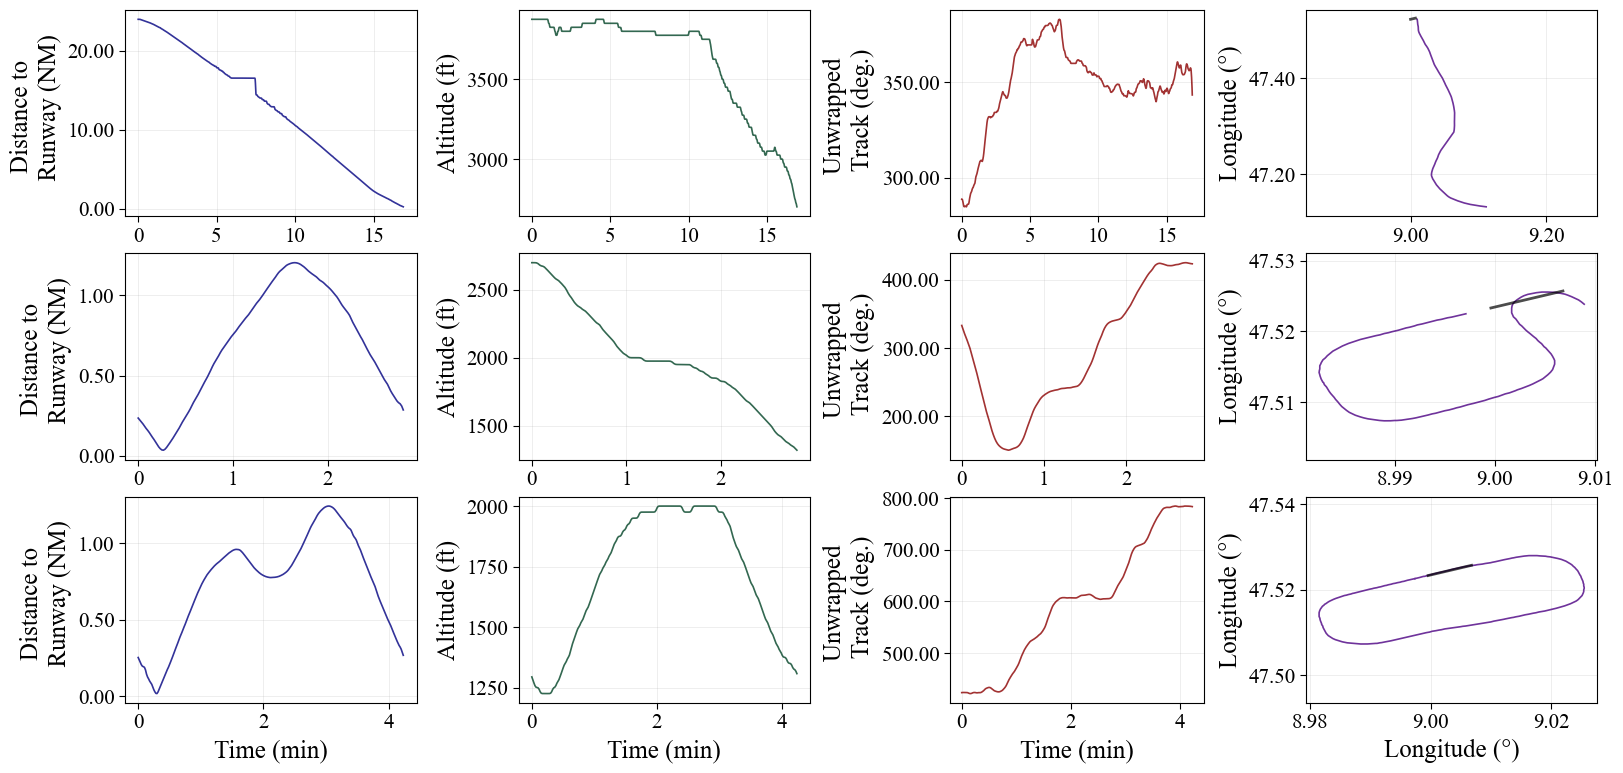

In [90]:
# Get results, predictions, and circuit info from the analysis
results, predictions, ncircuits, indexes = lommis_func.find_aerodrome_circuits(
    traff_set_filtered[3], 
    airports['LSZT'], 
    rwy='24', 
    scale=1.5, 
    sigma=1.0,
    debug=False, 
    plot=False
)

print(f"Found {ncircuits} airdrome circuits")
print(f"Number of segments: {len(results)}")

# Create publication-quality academic plot - ONE SEGMENT PER ROW
fig = plot_flight_segments_academic(
    results, 
    airports['LSZT'],
    segment_indices=[0,1,2] if len(results) > 1 else [0],  # Select segments
    features=['distance', 'altitude', 'track', 'map'],  # Now includes map support
    layout_type='grid',  # Grid layout: one segment per row, features as columns
    figure_size=(19, 9),  # Adjusted size for grid layout
    predictions=[],
    #predictions=["TRUE" if pred == 1 else "FALSE" for pred in predictions],
    color_scheme='ieee',  # Professional color scheme
    #
    # save_path='Statistics/flight_analysis_paper.pdf',
    dpi=300
)

plt.show()

In [14]:
lommis_func.find_aerodrome_circuits( # 3 is not bad
    traff_set_filtered[3], airports['LSZT'], 
    rwy='24', scale=1.5, debug=False, plot=True)

(array([[array([23.99110426, 23.99086302, 23.99034742, ...,  0.28647998,
                 0.27299397,  0.26004767], shape=(1013,))               ,
         array([93.04955626, 93.05126836, 93.05493228, ..., 36.12426024,
                33.25924753, 30.42813717], shape=(1013,))               ,
         array([3875.        , 3875.        , 3875.        , ..., 2717.27651497,
                2712.3900559 , 2708.15553388], shape=(1013,))                   ,
         array([288.62776159, 288.50364826, 288.30500919, ..., 347.8129056 ,
                344.5787777 , 340.79639211], shape=(1013,))                 ,
         10782    2025-03-05 14:47:38+00:00
         10783    2025-03-05 14:47:39+00:00
         10784    2025-03-05 14:47:40+00:00
         10785    2025-03-05 14:47:41+00:00
         10786    2025-03-05 14:47:42+00:00
                            ...
         3562     2025-03-05 15:04:27+00:00
         3563     2025-03-05 15:04:28+00:00
         3564     2025-03-05 15:04:29+00:00
    

## Plot flight phases plot

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

def plot_flight_type(flight, airport: str, debug: bool = False):
    flight.data['timestamp'] = flight.data['timestamp'].dt.tz_convert(None).astype('datetime64[ns]')
    flight.data['timestamp'] = flight.data['timestamp'].dt.tz_localize('UTC')

    flight = flight.phases()
    flight.data['type'] = 'N/A'

    # DEPARTURE
    phase_shift = (flight.data.phase.shift() == 'CLIMB') & (flight.data.phase != 'CLIMB')
    departure_index = phase_shift[1:].idxmax()
    flight.data.loc[:departure_index, 'type'] = 'D : Departure (Abflug)'

    # CIRCUITS FIRST 
    results, predictions, ncircuits, indexes = lommis_func.find_aerodrome_circuits(
        flight, 
        airport, 
        rwy='24', 
        scale=1.5, 
        debug=False, 
        plot=False
    )
    
    if ncircuits >= 1:
        col_index = flight.data.columns.get_loc('type')
        for start_index, end_index in indexes:
            flight.data.iloc[start_index:end_index, col_index] = 'V : Volte (Platzrunde)'
            if debug:
                print(f"Circuit between {flight.data.timestamp.iloc[start_index]} and {flight.data.timestamp.iloc[end_index]}")

    # PRESENTATION ENHANCEMENT: Truncate after first circuit + short arrival  
    if ncircuits >= 1:
        # Find the end of the first circuit
        first_circuit_end = indexes[0][1]  # End index of first circuit
        first_circuit_end_time = flight.data.timestamp.iloc[first_circuit_end]
        
        # Target: 2 minutes after first circuit ends (around 08:27)
        target_end_time = first_circuit_end_time + pd.Timedelta(minutes=2)
        
        # Find index closest to target time using .iloc based indexing
        time_diffs = (flight.data['timestamp'] - target_end_time).abs()
        
        # Find row with minimum time difference
        min_diff_idx = time_diffs.idxmin()
        
        # Get the position of this row in the DataFrame
        truncate_pos = flight.data.index.get_loc(min_diff_idx)
        first_circuit_end_pos = flight.data.index.get_loc(first_circuit_end)
        
        # Make sure truncation is after circuit end + some minimal arrival
        truncate_pos = max(truncate_pos, first_circuit_end_pos + 10)
        
        if debug:
            print(f"FIXED TRUNCATION:")
            print(f"Original length: {len(flight.data)}")
            print(f"First circuit ends at: {first_circuit_end_time}")  
            print(f"Target end time: {target_end_time}")
            print(f"Min diff index: {min_diff_idx}, position: {truncate_pos}")
            
        # TRUNCATE DATA
        flight.data = flight.data.iloc[:truncate_pos + 1].copy()
        
        # Reset index to avoid issues
        flight.data = flight.data.reset_index(drop=True)
        
        # Now mark everything after first circuit as arrival
        # Find new position of first circuit end after reset
        circuit_end_time = first_circuit_end_time
        post_circuit_idx = None
        for i in range(len(flight.data)):
            if flight.data.timestamp.iloc[i] >= circuit_end_time:
                post_circuit_idx = i
                break
                
        if post_circuit_idx is not None:
            flight.data.loc[post_circuit_idx:, 'type'] = 'A : Arrival (Anflug)'
        
        if debug:
            print(f"New flight ends at: {flight.data.timestamp.iloc[-1]}")
            print(f"New length: {len(flight.data)}")
            print(f"Duration: {(flight.data.timestamp.iloc[-1] - flight.data.timestamp.iloc[0]).total_seconds() / 60:.1f} minutes")

    # ARRIVAL (fallback if no circuits)
    else:
        phase_shift = (flight.data.phase.shift() != flight.data.phase) & (flight.data.phase == 'DESCENT')
        descent_indices = phase_shift[phase_shift].index
        for index in np.flip(descent_indices):
            subsequent_phases = flight.data.loc[index+1:, 'phase']
            if not any(subsequent_phases.isin(['CLIMB'])):
                flight.data.loc[index:, 'type'] = 'A : Arrival (Anflug)'
                break

    # === Styling ===
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 14,
        'axes.labelsize': 15,
        'axes.titlesize': 15,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
        'text.color': 'black',
        'axes.edgecolor': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'figure.dpi': 150
    })

    # Color maps
    phase_colors = {
        'CLIMB': '#c0ffc0',
        'DESCENT': '#ffd6d6',
        'LEVEL': '#fff07a',
        'NA': '#e0e0e0',
    }

    fig, ax = plt.subplots(figsize=(14, 5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    timestamps = flight.data['timestamp']
    altitudes = flight.data['altitude']

    # === Background shaded by flight.phase
    current_phase = flight.data['phase'].iloc[0]
    start_idx = 0
    for i in range(1, len(flight.data)):
        if flight.data['phase'].iloc[i] != current_phase or i == len(flight.data) - 1:
            start = timestamps.iloc[start_idx]
            end = timestamps.iloc[i]
            color = phase_colors.get(current_phase, '#eeeeee')
            ax.axvspan(start, end, facecolor=color, alpha=0.6)
            current_phase = flight.data['phase'].iloc[i]
            start_idx = i

    # === Altitude line
    ax.plot(timestamps, altitudes, label='Altitude', color='blue', linewidth=1.5)
    ax.set_ylabel("Altitude [ft]")
    ax.set_xlabel("Time [UTC]")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Dashed horizontal lines
    y_min, y_max = ax.get_ylim()
    bar_height = (y_max - y_min) * 0.001
    levels = np.linspace(y_min, y_max, 5)
    for y in levels:
        ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    type_colors = {
        'D : Departure (Abflug)': ('orange', 'D', 0.1 * bar_height),
        'A : Arrival (Anflug)': ('deepskyblue', 'A', 0.25 * bar_height),
        'V : Volte (Platzrunde)': ('teal', 'V', 0.4 * bar_height),
        'N/A': ('crimson', 'N/A', 0.05 * bar_height)
    }
        
    # === Horizontal bars for 'type' (always at bottom!)
    current_type = flight.data['type'].iloc[0]
    start_idx = 0
    for i in range(1, len(flight.data)):
        if flight.data['type'].iloc[i] != current_type or i == len(flight.data) - 1:
            start_time = timestamps.iloc[start_idx]
            end_time = timestamps.iloc[i]
            color, label, pos_factor = type_colors.get(current_type, ('gray', '', 0.02))
            bar_y = y_min + (y_max - y_min) * pos_factor
            ax.hlines(y=bar_y, xmin=start_time, xmax=end_time, linewidth=8, color=color, zorder=5)
            ax.axvline(x=start_time, linestyle='--', color='black', linewidth=0.6)
            ax.text((start_time + (end_time - start_time)/2), bar_y - 20*bar_height,
                    label, ha='center', va='top', fontsize=25, fontweight='bold', color=color)
            current_type = flight.data['type'].iloc[i]
            start_idx = i

    # === Legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', label='Altitude'),
        mpatches.Patch(color=phase_colors['LEVEL'], label='LEVEL'),
        mpatches.Patch(color=phase_colors['CLIMB'], label='CLIMB'),
        mpatches.Patch(color=phase_colors['DESCENT'], label='DESCENT'),
        mpatches.Patch(color=phase_colors['NA'], label='NA'),
        plt.Line2D([0], [0], color='orange', lw=6, label='D : Departure (Abflug)'),
        plt.Line2D([0], [0], color='deepskyblue', lw=6, label='A : Arrival (Anflug)'),
        plt.Line2D([0], [0], color='teal', lw=6, label='V : Volte (Platzrunde)'),
        plt.Line2D([0], [0], color='crimson', lw=6, label='N/A')
    ]
    legend = ax.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1.01, 0.5),
        title="Legend",
        frameon=True,
        facecolor='white',
        edgecolor='black',
        fontsize=11,
        title_fontsize=12
    )

    #ax.set_title("Flight Phases Over Time")
    plt.tight_layout()
    #fig.savefig("aerodrome_flight_types.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

In [ ]:
# Create publication-quality academic plot - ONE SEGMENT PER ROW
fig = plot_flight_segments_academic(
    results, 
    airports['LSZT'],
    segment_indices=[0,1,2] if len(results) > 1 else [0],  # Select segments
    features=['distance', 'angle', 'altitude', 'track', 'map'],  # Now includes map support
    layout_type='grid',  # Grid layout: one segment per row, features as columns
    figure_size=(18, 8),  # Adjusted size for grid layout
    predictions=["TRUE" if pred == 1 else "FALSE" for pred in predictions],
    color_scheme='ieee',  # Professional color scheme
    #
    # save_path='Statistics/flight_analysis_paper.pdf',
    dpi=300
)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# Get fresh flight
flight = traff_set_filtered[19]

# Prepare data
flight.data['timestamp'] = flight.data['timestamp'].dt.tz_convert(None).astype('datetime64[ns]')
flight.data['timestamp'] = flight.data['timestamp'].dt.tz_localize('UTC')

flight = flight.phases()
flight.data['type'] = 'N/A'

# DEPARTURE
phase_shift = (flight.data.phase.shift() == 'CLIMB') & (flight.data.phase != 'CLIMB')
departure_index = phase_shift[1:].idxmax()
flight.data.loc[:departure_index, 'type'] = 'D : Departure (Abflug)'

# CIRCUITS 
results, predictions, ncircuits, indexes = lommis_func.find_aerodrome_circuits(
    flight, 
    airports["LSZT"], 
    rwy='24', 
    scale=1.5, 
    debug=False, 
    plot=False,
    sigma = 1.0
)

if ncircuits >= 1:
    # Mark circuits FIRST
    col_index = flight.data.columns.get_loc('type')
    for start_index, end_index in indexes:
        flight.data.iloc[start_index:end_index, col_index] = 'V : Volte (Platzrunde)'

    # PRESENTATION TRUNCATION: End flight 2 minutes after first circuit
    first_circuit_end = indexes[0][1]
    first_circuit_end_time = flight.data.timestamp.iloc[first_circuit_end]
    target_end_time = first_circuit_end_time + pd.Timedelta(minutes=2)
    
    # Find and apply truncation
    mask = flight.data['timestamp'] <= target_end_time
    if mask.any():
        truncate_idx = mask[::-1].idxmax()  # Last True value
        
        # TRUNCATE the data
        flight.data = flight.data.loc[:truncate_idx].copy()
        
        # NOW mark everything from circuit end onwards as arrival (no gaps!)
        circuit_end_time = first_circuit_end_time
        remaining_mask = flight.data['timestamp'] >= circuit_end_time  # >= instead of > to eliminate gap
        
        # Only mark the part FROM the circuit end as arrival (preserve Departure and Volte)
        flight.data.loc[remaining_mask, 'type'] = 'A : Arrival (Anflug)'
        
        print(f"Truncated flight from {len(mask)} to {len(flight.data)} points")
        print(f"Flight now ends at: {flight.data.timestamp.iloc[-1]}")
        print(f"Type distribution:")
        print(flight.data['type'].value_counts())

# VISUALIZATION
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 150
})

phase_colors = {
    'CLIMB': '#c0ffc0',
    'DESCENT': '#ffd6d6', 
    'LEVEL': '#fff07a',
    'NA': '#e0e0e0',
}

fig, ax = plt.subplots(figsize=(14, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

timestamps = flight.data['timestamp']
altitudes = flight.data['altitude']

# Background phases
current_phase = flight.data['phase'].iloc[0]
start_idx = 0
for i in range(1, len(flight.data)):
    if flight.data['phase'].iloc[i] != current_phase or i == len(flight.data) - 1:
        start = timestamps.iloc[start_idx]
        end = timestamps.iloc[i]
        color = phase_colors.get(current_phase, '#eeeeee')
        ax.axvspan(start, end, facecolor=color, alpha=0.6)
        current_phase = flight.data['phase'].iloc[i]
        start_idx = i

# Altitude line
ax.plot(timestamps, altitudes, label='Altitude', color='blue', linewidth=1.5)
ax.set_ylabel("Altitude [ft]")
ax.set_xlabel("Time [UTC]")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Type bars
y_min, y_max = ax.get_ylim()
bar_height = (y_max - y_min) * 0.001

type_colors = {
    'D : Departure (Abflug)': ('orange', 'D', 0.18 * bar_height),
    'A : Arrival (Anflug)': ('deepskyblue', 'A', 0.15 * bar_height),
    'V : Volte (Platzrunde)': ('teal', 'V', 0.2 * bar_height),
    'N/A': ('crimson', 'N/A', 0.05 * bar_height)
}

current_type = flight.data['type'].iloc[0]
start_idx = 0
for i in range(1, len(flight.data)):
    if flight.data['type'].iloc[i] != current_type or i == len(flight.data) - 1:
        start_time = timestamps.iloc[start_idx]
        end_time = timestamps.iloc[i]
        color, label, pos_factor = type_colors.get(current_type, ('gray', '', 0.02))
        bar_y = y_min + (y_max - y_min) * pos_factor
        ax.hlines(y=bar_y, xmin=start_time, xmax=end_time, linewidth=8, color=color, zorder=5)
        ax.axvline(x=start_time, linestyle='--', color='black', linewidth=0.6)
        ax.text((start_time + (end_time - start_time)/2), bar_y - 30*bar_height,
                label, ha='center', va='top', fontsize=25, fontweight='bold', color=color)
        current_type = flight.data['type'].iloc[i]
        start_idx = i

# Legend
legend_elements = [
    plt.Line2D([0], [0], color='blue', label='Altitude'),
    mpatches.Patch(color=phase_colors['LEVEL'], label='LEVEL'),
    mpatches.Patch(color=phase_colors['CLIMB'], label='CLIMB'),
    mpatches.Patch(color=phase_colors['DESCENT'], label='DESCENT'),
    mpatches.Patch(color=phase_colors['NA'], label='NA'),
    plt.Line2D([0], [0], color='orange', lw=6, label='D : Departure (Abflug)'),
    plt.Line2D([0], [0], color='deepskyblue', lw=6, label='A : Arrival (Anflug)'),
    plt.Line2D([0], [0], color='teal', lw=6, label='V : Volte (Platzrunde)'),
    plt.Line2D([0], [0], color='crimson', lw=6, label='N/A')
]
legend = ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    title="Legend",
    frameon=True,
    facecolor='white',
    edgecolor='black',
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout()
plt.show()

# Plot Initial Concept Detection

In [ ]:
flight = traff_set_filtered[15]
airport = airports["LSZT"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lommis_func
from traffic.data import airports
from scipy.signal import find_peaks

rwy, _ = lommis_func.detect_runway(flight, airport)
extreme1, extreme2, center = lommis_func.retrieve_runway_information(airport, rwy)
dist_to_runway = np.array( flight.distance(center).data[["distance"]] ).flatten()

lat = flight.data.latitude.values
lon = flight.data.longitude.values

angle = lommis_func.compute_alignment_angle(extreme1.latitude, extreme1.longitude, extreme2.latitude, extreme2.longitude,
                                            lon, lat)

unwrap_track = lommis_func.unwrap_track(flight.data.track.values, flight.data.timestamp.values)

DISTANCE_THRESHOLD_NM = 2.0
mask = dist_to_runway <= DISTANCE_THRESHOLD_NM

ts = flight.data.timestamp[mask]
alt = flight.data.altitude.values[mask]
labels = flight.phases().data.phase[mask]

angle = angle[mask]
unwrap_track = unwrap_track[mask]
dist_to_runway = dist_to_runway[mask]

ts_series = pd.to_datetime(ts)
ts_relative = ts_series - ts_series.iloc[0]
ts = ts_relative.dt.total_seconds().values

phasecolors = {
    "GROUND": "black",
    "CLIMB": "green",
    "DESCENT": "orange",
    "LEVEL": "red",
    "CRUISE": "purple",
    "NA": "red",
}
colors = [phasecolors[lbl] for lbl in labels]

# Find peaks and valleys in altitude
peaks, _ = find_peaks(dist_to_runway)
valleys, _ = find_peaks(-dist_to_runway)

fig = plt.figure(figsize=(10, 12))

plt.subplot(711)
plt.scatter(ts, alt, marker=".", c=colors, lw=0)
plt.ylabel("Altitude (ft)")

plt.axvline(1722.0-10, color="black", linestyle="--", lw=1.5)
plt.axvline(1992.0-10, color="black", linestyle="--", lw=1.5)

plt.xlim([1500, 2300])
plt.xticks([])

# Add segment labels
max_alt = np.max(alt)
plt.text(1600, max_alt - 300, 'Segment 1', ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.text(1857, max_alt - 300, 'Segment 2', ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.text(2100, max_alt - 300, 'Segment 3', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.subplot(712)
plt.scatter(ts, dist_to_runway, marker=".", c=colors, lw=0)
plt.scatter(ts[peaks], dist_to_runway[peaks], marker='^', color='cyan', s=50, edgecolor='black', linewidth=0.5)
plt.scatter(ts[valleys], dist_to_runway[valleys], marker='v', color='royalblue', s=50, edgecolor='black', linewidth=0.5)
plt.ylabel("Distance to \n Runway \n (NM)")

plt.axvline(1722.0-10, color="black", linestyle="--", lw=1.5)
plt.axvline(1992.0-10, color="black", linestyle="--", lw=1.5)

plt.xlim([1500, 2300])
plt.xlabel("Time (s)")

# Create legend handles
phase_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=phase) for phase, color in phasecolors.items()]
peak_handle = plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='cyan', markersize=8, markeredgecolor='black', label='Peaks')
valley_handle = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='royalblue', markersize=8, markeredgecolor='black', label='Valleys')
flight_handle = plt.Line2D([0], [0], color='black', linestyle='--', lw=1.5, label='Segment Limit')

# Add separate legends
fig.legend(handles=phase_handles, loc='center right', bbox_to_anchor=(0.88, 0.8), fontsize='small', title='Flight Phases')
fig.legend(handles=[peak_handle, valley_handle, flight_handle], loc='center right', bbox_to_anchor=(0.9, 0.71), fontsize='small', title='')

plt.subplots_adjust(right=0.75)
plt.show()

In [ ]:
lommis_func.detect_shifts(ts, angle, phases=labels, min_separation=100, min_magnitude=160, use_curvature=True, use_derivative=True, plot=True)

# Plot Angle

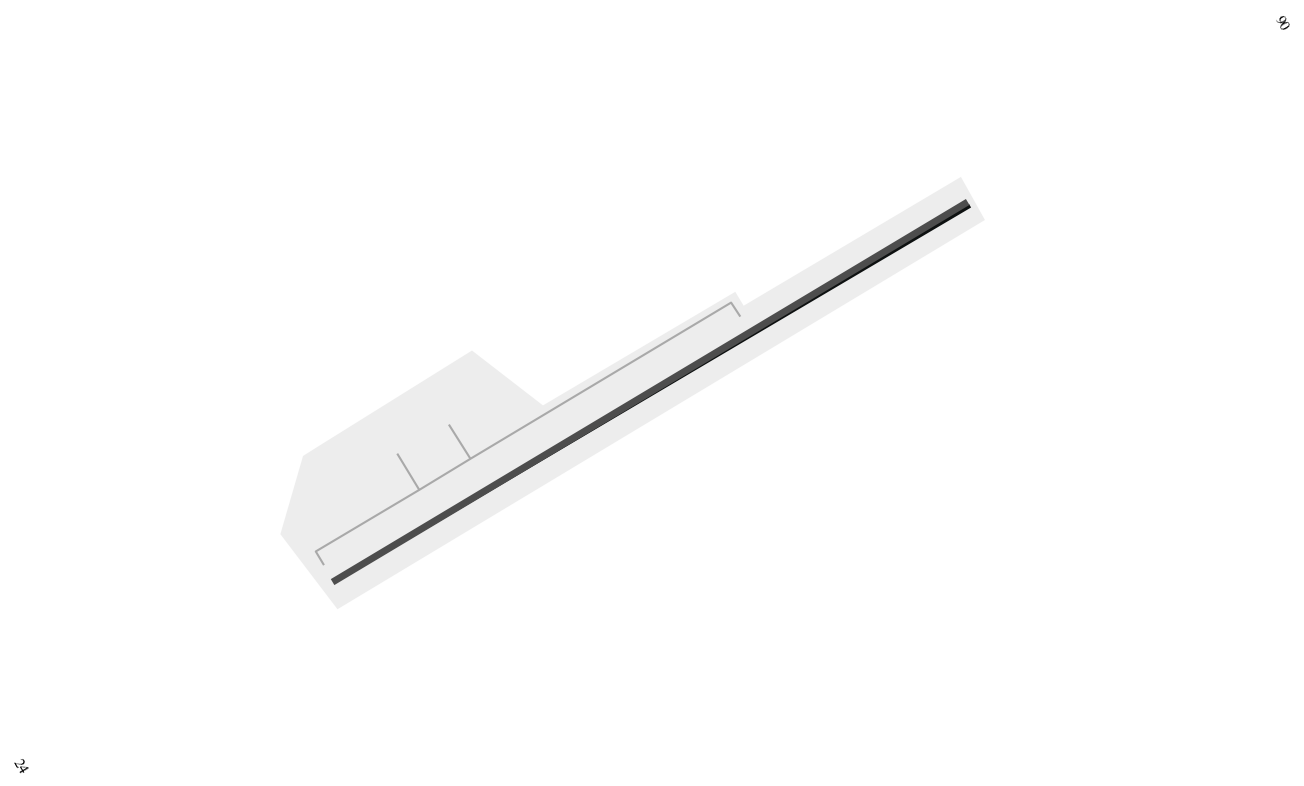

In [2]:

with plt.style.context('traffic'):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    airports['LSZT'].plot(ax, labels=dict(fontsize=11))
    ax.spines['geo'].set_visible(False)

In [14]:
airports["LSZT"].runways.data

,latitude,longitude,bearing,name
0,47.5257,9.0068,243.800221,06
1,47.5233,8.9996,63.794910,24


In [84]:
# Define aircraft position (example point P)
# You can modify these coordinates to show different aircraft positions
aircraft_lat = 47.5268  # Example aircraft latitude
aircraft_lon = 8.999  # Example aircraft longitude


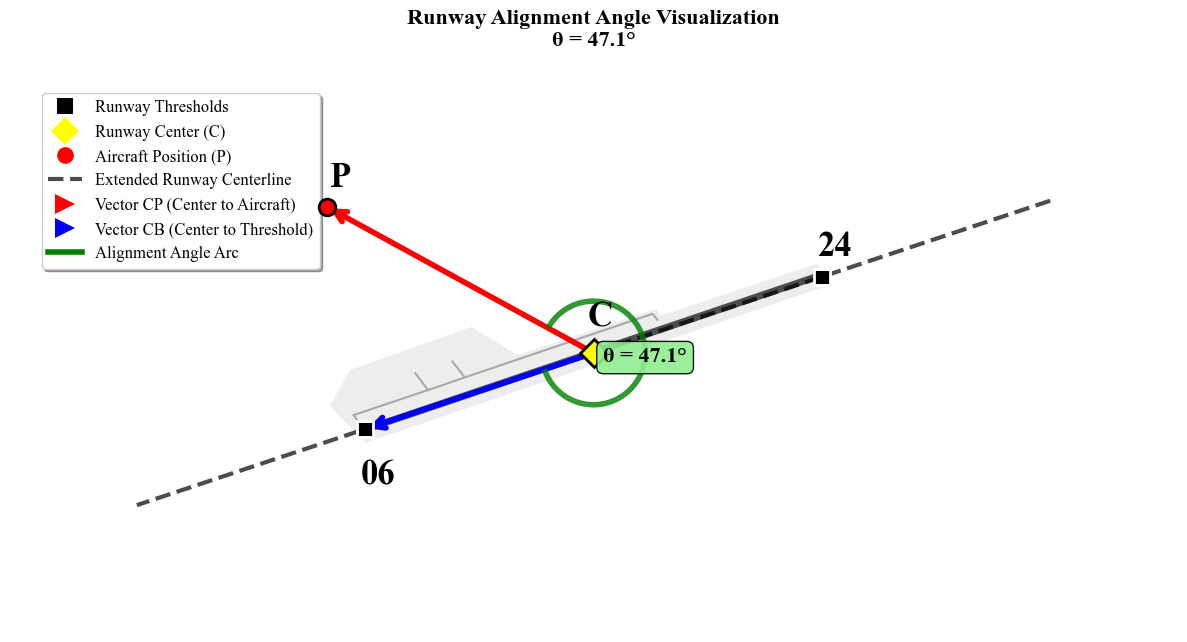

In [85]:
# Runway Alignment Angle Visualization
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.patches import Polygon, FancyBboxPatch
from matplotlib.patches import Arc
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
import matplotlib.transforms as transforms

# Get runway information
airport = airports["LSZT"]
runway = '06'
extreme1, extreme2, center = lommis_func.retrieve_runway_information(airport, runway)

# Calculate alignment angle using the function
aircraft_lats = np.array([aircraft_lat])
aircraft_lons = np.array([aircraft_lon])
alignment_angle = lommis_func.compute_alignment_angle(
    extreme1.latitude, extreme1.longitude, 
    extreme2.latitude, extreme2.longitude,
    aircraft_lons, aircraft_lats
)[0]

# Create the plot
with plt.style.context('traffic'):
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

    # Plot airport
    airport.plot(ax)
    
    # Plot runway thresholds
    ax.plot(extreme1.longitude, extreme1.latitude, 's', color='black', markersize=12, 
            markeredgecolor='white', markeredgewidth=2, transform=ccrs.PlateCarree(), zorder=10)
    ax.plot(extreme2.longitude, extreme2.latitude, 's', color='black', markersize=12, 
            markeredgecolor='white', markeredgewidth=2, transform=ccrs.PlateCarree(), zorder=10)
    
    # Plot runway center
    ax.plot(center.longitude, center.latitude, 'D', color='yellow', markersize=14, 
            markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree(), zorder=11)
    
    # Plot aircraft position (Point P)
    ax.plot(aircraft_lon, aircraft_lat, 'o', color='red', markersize=12, 
            markeredgecolor='black', markeredgewidth=2, transform=ccrs.PlateCarree(), zorder=12)
    
    # Draw extended runway centerline
    runway_length = geodesic((extreme1.latitude, extreme1.longitude), 
                           (extreme2.latitude, extreme2.longitude)).meters
    
    # Calculate runway direction vector
    runway_dir_lat = extreme2.latitude - extreme1.latitude
    runway_dir_lon = extreme2.longitude - extreme1.longitude
    
    # Normalize and extend the runway centerline
    extend_factor = 0.5  # Extend runway centerline by this factor
    extended_start_lat = extreme1.latitude - extend_factor * runway_dir_lat
    extended_start_lon = extreme1.longitude - extend_factor * runway_dir_lon
    extended_end_lat = extreme2.latitude + extend_factor * runway_dir_lat
    extended_end_lon = extreme2.longitude + extend_factor * runway_dir_lon
    
    # Draw extended runway centerline
    ax.plot([extended_start_lon, extended_end_lon], 
            [extended_start_lat, extended_end_lat], 
            'k--', linewidth=3, alpha=0.7, transform=ccrs.PlateCarree(), zorder=5)
    
    # Draw vector from runway center to aircraft (CP) with bigger arrow
    ax.annotate('', xy=(aircraft_lon, aircraft_lat), xytext=(center.longitude, center.latitude),
                arrowprops=dict(arrowstyle='->', color='red', lw=4, mutation_scale=20),
                transform=ccrs.PlateCarree(), zorder=6)
    
    # Draw vector from runway center to runway threshold (CB) with bigger arrow
    ax.annotate('', xy=(extreme2.longitude, extreme2.latitude), xytext=(center.longitude, center.latitude),
                arrowprops=dict(arrowstyle='->', color='blue', lw=4, mutation_scale=20),
                transform=ccrs.PlateCarree(), zorder=6)
    
    # Add labels
    ax.text(extreme1.longitude + 0.0002, extreme1.latitude + 0.0002, '24', 
            fontsize=25, fontweight='bold', ha='center', va='bottom', 
            transform=ccrs.PlateCarree(), zorder=15)
    ax.text(extreme2.longitude + 0.0002, extreme2.latitude - 0.001, '06', 
            fontsize=25, fontweight='bold', ha='center', va='bottom', 
            transform=ccrs.PlateCarree(), zorder=15)
    ax.text(center.longitude + 0.0001, center.latitude + 0.0003, 'C', 
            fontsize=25, fontweight='bold', ha='center', va='bottom', 
            transform=ccrs.PlateCarree(), zorder=15)
    ax.text(aircraft_lon + 0.0002, aircraft_lat + 0.0002, 'P', 
            fontsize=25, fontweight='bold', ha='center', va='bottom', 
            transform=ccrs.PlateCarree(), zorder=15)
    
    # Calculate angles for the vectors
    # Vector CB angle (runway centerline direction)
    cb_angle = np.arctan2(extreme2.latitude - center.latitude, extreme2.longitude - center.longitude)
    # Vector CP angle (to aircraft)
    cp_angle = np.arctan2(aircraft_lat - center.latitude, aircraft_lon - center.longitude)
    
    # Calculate smaller radius for inner arc
    cp_distance = geodesic((center.latitude, center.longitude), (aircraft_lat, aircraft_lon)).meters
    cb_distance = geodesic((center.latitude, center.longitude), (extreme2.latitude, extreme2.longitude)).meters
    inner_radius = min(cp_distance, cb_distance) * 0.3  # 30% of the shorter vector
    
    # Draw INNER semicircle angle arc
    arc = Arc((center.longitude, center.latitude), 
              width=2*inner_radius/111000, height=2*inner_radius/111000,  # Convert meters to degrees
              angle=0, theta1=np.degrees(cb_angle), theta2=np.degrees(cp_angle),
              color='green', linewidth=4, alpha=0.8, transform=ccrs.PlateCarree(), zorder=7)
    ax.add_patch(arc)
    
    # Add angle annotation at the inner arc midpoint
    arc_mid_angle = (cp_angle + cb_angle) / 2
    arc_label_lat = center.latitude + (inner_radius/111000) * np.sin(arc_mid_angle)
    arc_label_lon = center.longitude + (inner_radius/111000) * np.cos(arc_mid_angle)
    
    ax.text(arc_label_lon, arc_label_lat, f'θ = {alignment_angle:.1f}°', 
            fontsize=16, fontweight='bold', ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.9),
            transform=ccrs.PlateCarree(), zorder=16)
    
    # Set extent
    all_lons = [extreme1.longitude, extreme2.longitude, aircraft_lon, extended_start_lon, extended_end_lon]
    all_lats = [extreme1.latitude, extreme2.latitude, aircraft_lat, extended_start_lat, extended_end_lat]
    
    lon_min, lon_max = min(all_lons), max(all_lons)
    lat_min, lat_max = min(all_lats), max(all_lats)
    
    pad_lon = max(0.002, 0.1 * (lon_max - lon_min))
    pad_lat = max(0.002, 0.1 * (lat_max - lat_min))
    
    ax.set_xlim(lon_min - pad_lon, lon_max + pad_lon)
    ax.set_ylim(lat_min - pad_lat, lat_max + pad_lat)
    
    # Add coastline for context
    ax.coastlines(resolution='10m', color='gray', alpha=0.5, linewidth=1)
    
    # Create legend with same symbols as plot
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markeredgecolor='white', 
               markersize=12, label='Runway Thresholds', linestyle='None'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='yellow', markeredgecolor='black', 
               markersize=14, label='Runway Center (C)', linestyle='None'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black',
               markersize=12, label='Aircraft Position (P)', linestyle='None'),
        Line2D([0], [0], color='black', linewidth=3, alpha=0.7, linestyle='--', label='Extended Runway Centerline'),
        Line2D([0], [0], marker='>', color='red', markersize=15, linestyle='None', label='Vector CP (Center to Aircraft)'),
        Line2D([0], [0], marker='>', color='blue', markersize=15, linestyle='None', label='Vector CB (Center to Threshold)'),
        Line2D([0], [0], color='green', linewidth=4, label='Alignment Angle Arc'),
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98), 
              fontsize=12, frameon=True, fancybox=True, shadow=True)
    
    # Clean look
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines['geo'].set_visible(False)
    
    plt.title(f'Runway Alignment Angle Visualization\nθ = {alignment_angle:.1f}°', 
              fontsize=16, fontweight='bold', pad=20)
    
plt.tight_layout()
plt.show()